In [1]:
## Preliminary arrangements: which companies and dates to choose?
import pandas as pd
import numpy as np
dfsym=pd.read_csv('data/companylist.csv',float_precision='high')
dfsym=dfsym[dfsym['MarketCap'] > 2000000000]
companies=dfsym['Symbol'].tolist()
dfsp500 = pd.read_csv('data/SANDP500.csv')
companies=dfsp500['Symbol'].tolist()

In [3]:
import glob
import os
path = r'data/NASDAQ'                     # use your path
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NAS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NAS=concatenated_df_NAS[concatenated_df_NAS['<ticker>'].isin(companies)]

path = r'data/NYSE'                     # use your path
all_files = glob.glob(os.path.join(path, "*.txt"))     
df_from_each_file = (pd.read_csv(f) for f in all_files)
concatenated_df_NYS   = pd.concat(df_from_each_file, ignore_index=True)
concatenated_df_NYS=concatenated_df_NYS[concatenated_df_NYS['<ticker>'].isin(companies)]

concatenated_df = pd.concat([concatenated_df_NAS,concatenated_df_NYS])

In [4]:
col_p = 'close'
concatenated_df.columns = ['ticker','date','open','high','low','close','vol']
concatenated_df=concatenated_df[concatenated_df['ticker'].isin(companies)]
concatenated_df=concatenated_df.merge(dfsp500,left_on='ticker',right_on='Symbol')
concatenated_df['ticker'] = concatenated_df['ticker']
df_price = concatenated_df[['ticker','date',col_p]]
df_price=df_price.drop_duplicates( keep='last')
df_price['date'] = pd.to_datetime(df_price['date'], format='%Y%m%d', errors='ignore')
df_price.set_index(['date','ticker'],inplace=True)
df_price=df_price.unstack()[col_p]
df_price.reset_index(inplace=True)
df_price.fillna(method='bfill',inplace=True)
df_price.fillna(method='ffill',inplace=True)

In [5]:
import scipy.signal
t = 1
for key in df_price.columns:
    if key not in companies:
        continue
    try:
        df_price[key] = np.log(df_price[key]) - np.log(df_price[key].shift(t))
    except:
        print (key)
df_price.set_index('date',inplace=True)

In [6]:
import math
def calc_d(x):
    x = round(x,3)
    d = math.sqrt(2 * (1 - x))
    return d
corr_dict = {}
corr_dist_dict = {}
T = 1
W = 63
x = []
y = []
for i in range(2007,2017):
        dkey = i
        corr_dict[dkey]=df_price.iloc[i:(i+W)].corr(method='pearson')
        corr_dict[dkey].fillna(0,inplace=True)
        corr_dist_dict[dkey] = corr_dict[dkey].applymap(calc_d)
        x.append(dkey)
        y.append(np.mean([abs(j) for j in corr_dict[dkey].values.flatten().tolist()]))
plt.plot(x,y)

In [7]:
elist_dict={}
for y in corr_dict.keys():
    df_price_corr = corr_dist_dict[y]
    elist = []
    outdict=df_price_corr.to_dict()
    for i in outdict.keys():
        for j in outdict[i].keys():
            elist.append([i,j,dict(weight=abs(outdict[i][j]),start=y,end=y+1)])
    print (len(elist))
    elist_dict[y] = elist

255025
255025
255025
255025
255025
255025
255025
255025
255025
255025


In [8]:
# Constructing a graph
import networkx as nx
import community
G_dict = {}
for y in elist_dict.keys():
    G=nx.Graph()
    elist = elist_dict[y]
    G.add_edges_from(elist)
    T = nx.minimum_spanning_tree(G)
    values = dfsp500.set_index('Symbol').to_dict(orient='dict')['Sector']
    for node, value in values.items():
        try:
            T.node[node]['Sector'] = value
        except:
            print ('Skipping ' + node)
    partition = community.best_partition(T)
    
    deg_cent=dict((k,float(v)) for k,v in nx.degree_centrality(T).items())
    #katz_cent=nx.katz_centrality(G)
    #eigen_cent= dict((k,float(v)) for k,v in nx.eigenvector_centrality(T).items()) 
    close_cent= dict((k,float(v)) for k,v in nx.closeness_centrality(T).items())  
    betw_cent= dict((k,float(v)) for k,v in nx.betweenness_centrality(T).items()) 
    nx.set_node_attributes(T, "community", partition)  
    nx.set_node_attributes(T, "degree", deg_cent)
    #nx.set_node_attributes(G, "katz", katz_cent)
    #nx.set_node_attributes(T, "eigenvector", eigen_cent)
    nx.set_node_attributes(T, "closeness", close_cent)
    nx.set_node_attributes(T, "betweenness", betw_cent)
    nx.set_node_attributes(T, 'start',y)
    nx.set_node_attributes(T, 'end',y+1)
    #G.remove_nodes_from(nx.isolates(G)) 
    #T = nx.minimum_spanning_tree(G)
    G_dict[y] = T

In [20]:
# Constructing a graph
import networkx as nx
M=nx.MultiGraph()
for y in G_dict.keys():
    M.add_nodes_from(G_dict[y].nodes(data=True))
    M.add_edges_from(G_dict[y].edges(data=True))

In [21]:
nx.write_gexf(M,'data/price-sp500-MST.gexf')

In [22]:
import xml.etree.ElementTree as ET
tree = ET.parse('data/price-sp500-MST.gexf')
root = tree.getroot()

In [23]:
for element in root.iter("{http://www.gexf.net/1.1draft}node"):
    #print (element.attrib)
    noden = element.attrib['id']
    for child in element:
        for i in range(len(child)):
            child.remove(child[0])
        for y in G_dict.keys():
            T = G_dict[y]
            n = 0
            try:
                for att in T.node[noden]:
                    new = ET.Element("{http://www.gexf.net/1.1draft}attvalue")
                    new.set('for',str(n))
                    new.set('value',str(T.node[noden][att]))
                    new.set('start',str(y))
                    new.set('end',str(y+1))
                    child.append(new)
                    #print (T.node[noden][att])
                    n = n + 1
            except:
                continue

In [24]:
tree.write('data/price-sp500-MST-o.gexf')

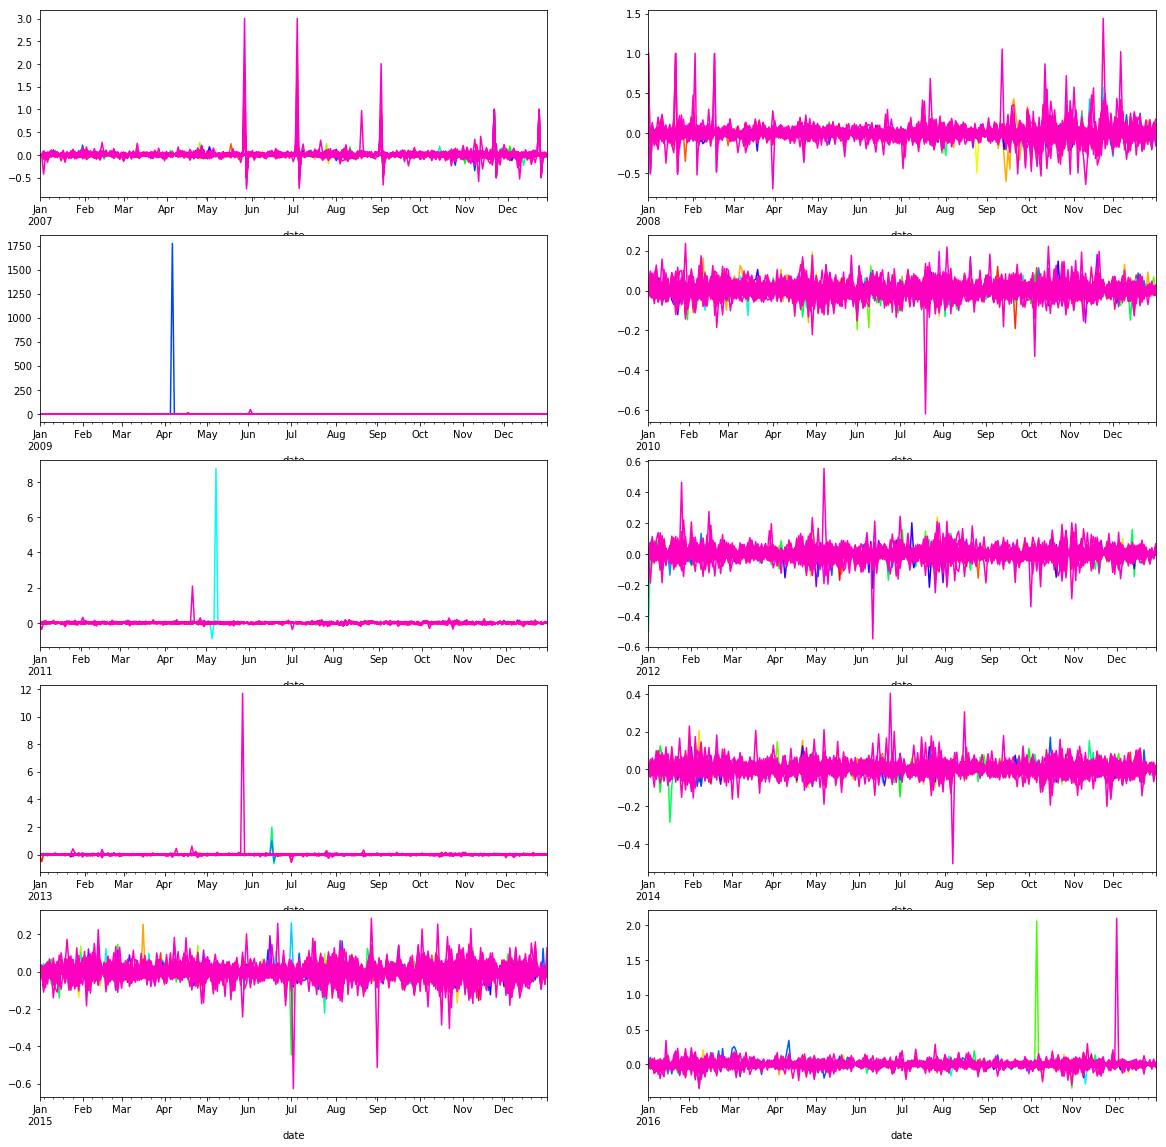

In [86]:
## A quick visualization: stock prices for each Dow Jones company
import matplotlib.pyplot as plt
import random as rn
import matplotlib as mpl
NUM_COLORS = len(companies)
cm = plt.get_cmap('gist_rainbow')
colors = [cm(4.*i/NUM_COLORS) for i in range(NUM_COLORS)]
rn.seed = len(companies)  # for choosing random colors
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y=2007
for row in ax:
    for col in row:
        yfs = str(y) + '0101'
        yfe = str(y) + '1231'
        n = 0
        for i in df_price.columns:
            df_price.loc[yfs:yfe][i].plot(ax=col,color=colors[n])
            n = n + 1
        y = y + 1
plt.show()

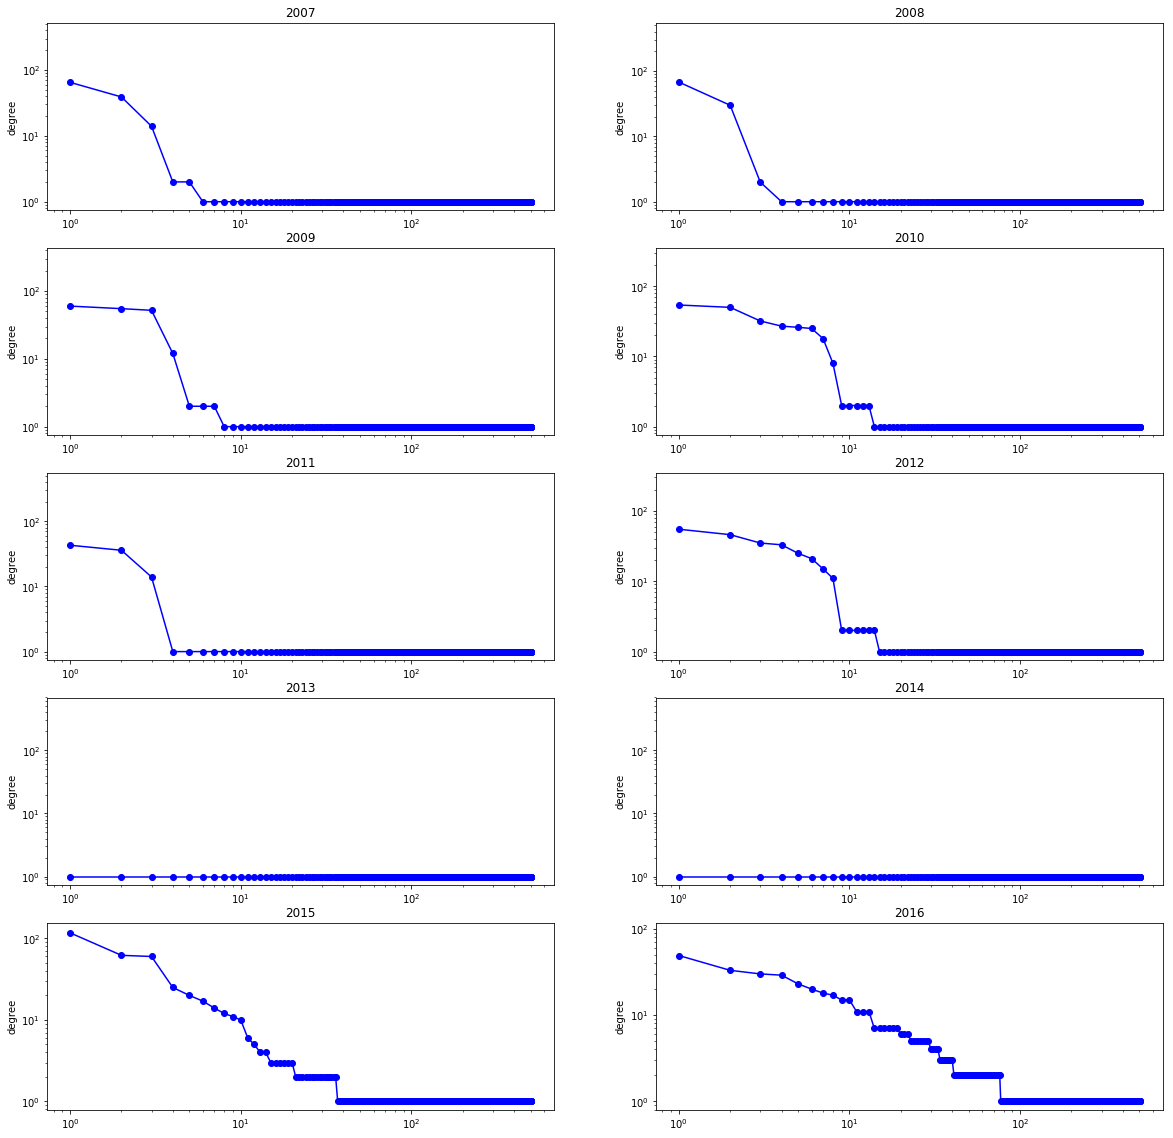

In [87]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y = 0
for row in ax:
    for col in row:
        try:
            T = G_dict[list(G_dict.keys())[y]]
        except:
            continue
        nodes, edges = T.order(), T.size()
        #print (nx.info(T))

        degree_sequence=sorted(nx.degree(T).values(),reverse=True) # degree sequence
        #print "Degree sequence", degree_sequence
        dmax=max(degree_sequence)

        col.loglog(degree_sequence,'b-',marker='o')
        col.set_title( str(list(G_dict.keys())[y]) )
        col.set_ylabel("degree")

        # draw graph in inset
        #col.set_axes([0.45,0.45,0.45,0.45])
        #Gcc=sorted(nx.connected_component_subgraphs(T), key = len, reverse=True)[0]
        #pos=nx.spring_layout(Gcc)
        #col.axis('off')
        #nx.draw_networkx_nodes(Gcc,pos,node_size=20)
        #nx.draw_networkx_edges(Gcc,pos,alpha=0.4)
        y = y + 1
plt.show()


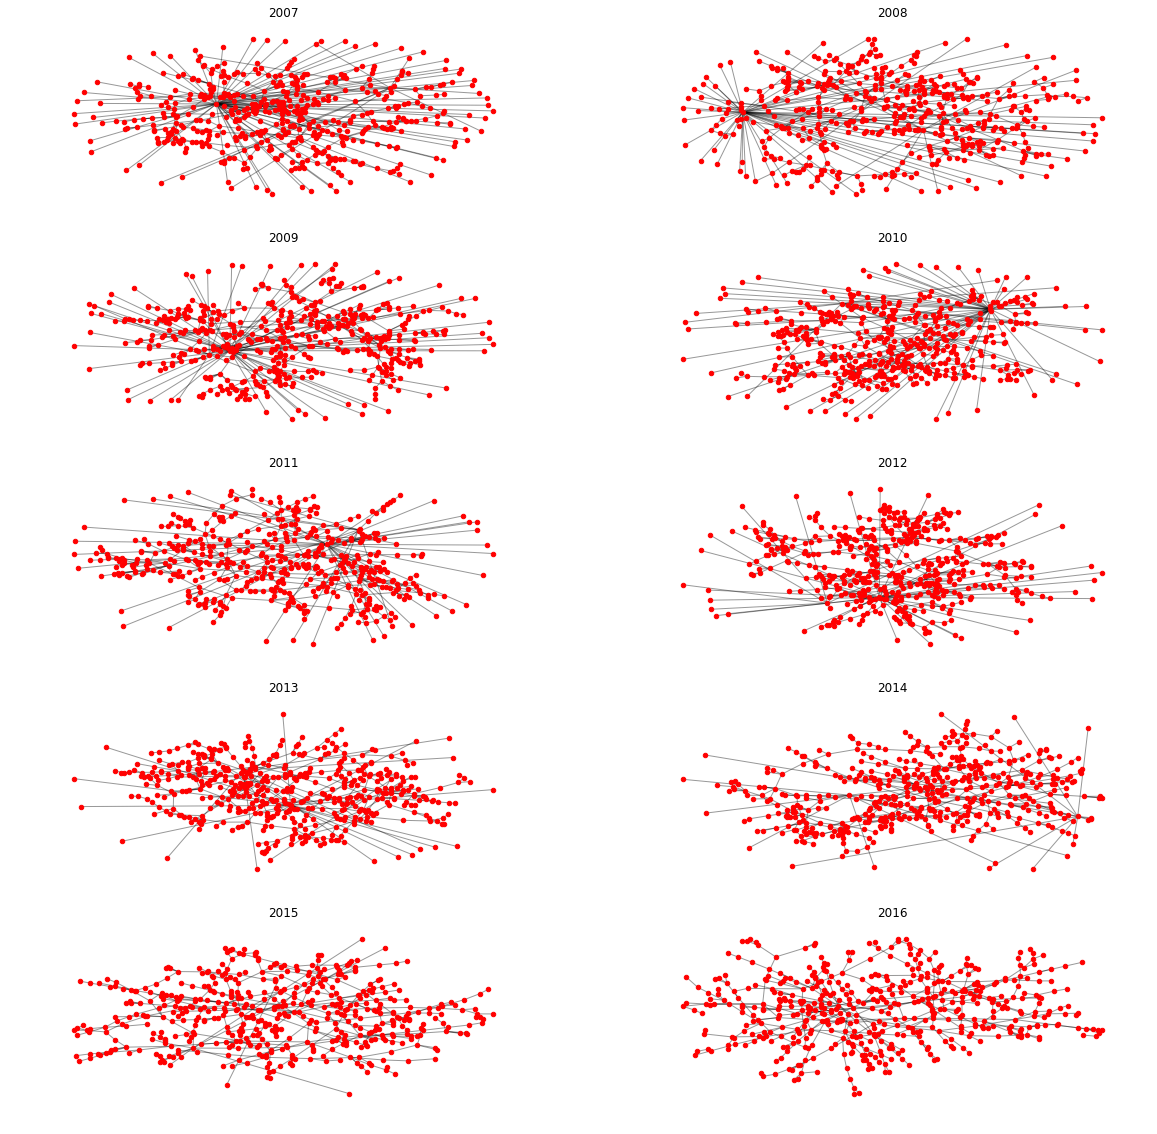

In [13]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y = 0
for row in ax:
    for col in row:
        col.axis('off')
        try:
            T = G_dict[list(G_dict.keys())[y]]
        except:
            continue
        col.set_title( str(list(G_dict.keys())[y]) )
        col.axis('off')
        Gcc=sorted(nx.connected_component_subgraphs(T), key = len, reverse=True)[0]
        pos=nx.spring_layout(Gcc)
        nx.draw_networkx_nodes(Gcc,pos,ax=col,node_size=20)
        nx.draw_networkx_edges(Gcc,pos,ax=col,alpha=0.4)
        y = y + 1
plt.show()

In [ ]:
## Explore graph properties
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=5,ncols=2,figsize=(20, 20))
y = 0
node = 'FB'
for row in ax:
    for col in row:
        col.axis('off')
        try:
            T = G_dict[list(G_dict.keys())[y]]
            nodelist = T.neighbors(node)
            for k in nodelist:
                for l in T.neighbors(k):
                    nodelist.append(l)
            nodelist.append(node)
            nodelist = list(set(nodelist))
            col.set_title( str(list(G_dict.keys())[y]) )
            col.axis('off')
            H = T.subgraph(nodelist)
            nx.draw(H,with_labels = True,layout=nx.spring_layout(H),ax=col)
        except:
            raise
        y = y + 1
plt.show()